In [1]:
import os
import sys
ROOT_DIR = os.path.abspath("../")

# uninstall all other opencv and install this
!pip3 install opencv-contrib-python==4.8.0.74
# Import lightstream
sys.path.append(ROOT_DIR)  # To find local version of the library
print(sys.path)
print(os.getcwd())
import lightstream.transforms as F
import albumentations as A
import matplotlib.pyplot as plt
import cv2
import pyvips

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Using cached opencv_contrib_python-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (67.8 MB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
['/tmp/pycharm_project_471/notebooks', '/tmp/pycharm_project_471', '/usr/local/lib/python311.zip', '/usr/local/lib/python3.11', '/usr/local/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/site-packages', '/opt/ASAP/bin', '/tmp/pycharm_project_471']
/tmp/pycharm_project_471/notebooks


In [2]:
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

In [3]:
image = cv2.imread('../images/image_3.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

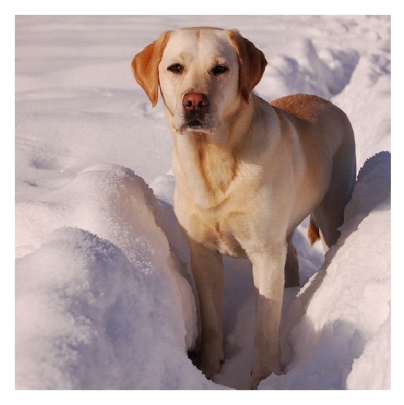

In [5]:
visualize(image)

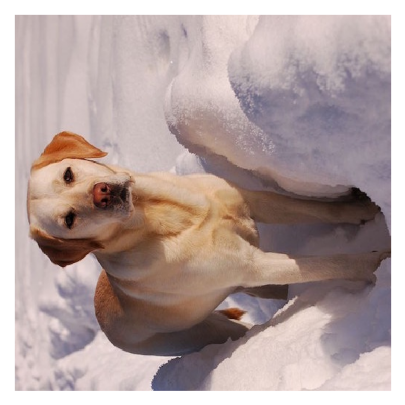

In [6]:
transforms = A.Compose([A.Transpose(p=1.0)])
new_img = transforms(image=image)
visualize(new_img['image'])

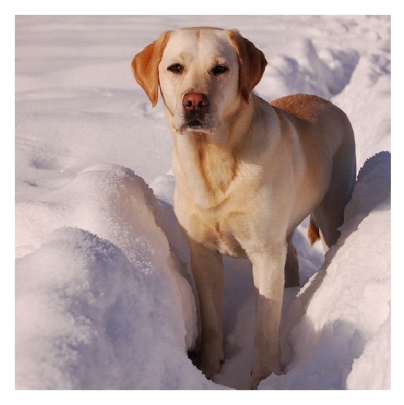

In [7]:
visualize(image)

In [8]:
pyvips_image = pyvips.Image.new_from_array(image)


transforms = F.Compose([
    F.HorizontalFlip(p=1.0),
    F.VerticalFlip(p=1.0),
    F.Transpose(p=1.0)
])

new_img = transforms(image=pyvips_image)

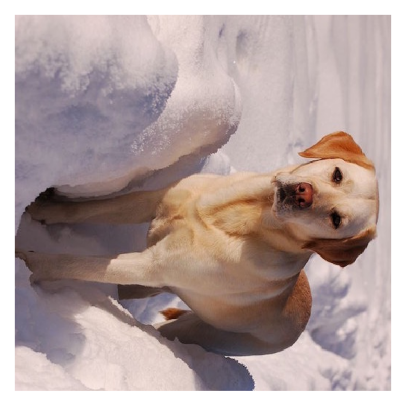

In [9]:
new_img = new_img['image'].numpy()
visualize(new_img)

In [144]:
import numpy as np
from numpy import linalg

rgb_from_hed = np.array([[0.65, 0.70, 0.29],
                         [0.07, 0.99, 0.11],
                         [0.27, 0.57, 0.78]])

rgb_from_hed[:,0] +=0.02
rgb_from_hed[:,1] +=0.02

hed_from_rgb = linalg.inv(rgb_from_hed)


print(hed_from_rgb)
print(rgb_from_hed.shape)
print()

test = np.ones((2,4,3))
test[...,1] += 1
test[...,2] += 2

test.shape
print(test)

[[ 1.86687326 -1.00845762 -0.55187552]
 [-0.0989089   1.13241655 -0.12292595]
 [-0.6192782  -0.48163213  1.58021822]]
(3, 3)

[[[1. 2. 3.]
  [1. 2. 3.]
  [1. 2. 3.]
  [1. 2. 3.]]

 [[1. 2. 3.]
  [1. 2. 3.]
  [1. 2. 3.]
  [1. 2. 3.]]]


In [11]:
z = test @ rgb_from_hed
print(z.shape)
z

(2, 4, 3)


array([[[1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85]],

       [[1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85]]])

In [94]:
image_pyvips = pyvips.Image.new_from_array(test)
H = pyvips.Image.sum(image_pyvips * [0.65, 0.07, 0.27])
E = pyvips.Image.sum(image_pyvips * [0.70, 0.99, 0.57])
D = pyvips.Image.sum(image_pyvips * [0.29, 0.11, 0.78])

HED = H.bandjoin([E,D])
HED.numpy()

array([[[1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85]],

       [[1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85],
        [1.6 , 4.39, 2.85]]])

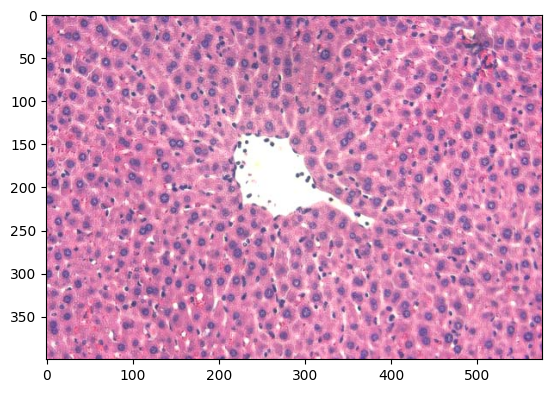

In [147]:
from skimage import data
from skimage.color import rgb2hed, hed2rgb
ihc_rgb = data.immunohistochemistry()
ihc_rgb = cv2.imread("../images/he.jpg")
ihc_rgb = cv2.cvtColor(ihc_rgb, cv2.COLOR_BGR2RGB)

plt.imshow(ihc_rgb)




## Manual numpy routine for stain deconvolution
color deconvolution from ruifrok et al. Apply the formula directly from skimage, based on the same steps in numpy functions, and in pyvips

### Using skimage function directly

1.0
0.433284085178761


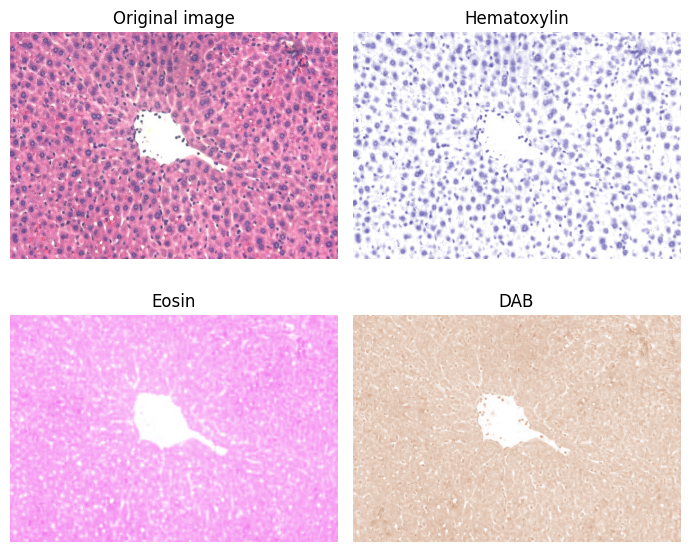

In [148]:
ihc_hed = rgb2hed(ihc_rgb)
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

print(ihc_d.max())
print(ihc_d.min())


fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[0].set_title("Original image")

ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_e)
ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image

ax[3].imshow(ihc_d)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

## Emulate stains in pyvips

In [169]:
rgb_from_hed = np.array([[0.65, 0.70, 0.29],
                         [0.07, 0.99, 0.11],
                         [0.27, 0.57, 0.78]])

rgb_from_hed[:,0] +=.1
rgb_from_hed[:,1] +=0.2

hed_from_rgb = linalg.inv(rgb_from_hed)


def separate_stains_pyvips(rgb: pyvips.Image):
    
    # adapted from https://github.com/scikit-image/scikit-image/blob/v0.22.0/skimage/color/colorconv.py#L1638
    # https://github.com/libvips/pyvips/issues/289
    # https://github.com/libvips/pyvips/issues/294

    
    # convert uint8 to [0,1] float 32
    if rgb.format == 'uchar':
        # dividing by 255 yields faithful results to skimage
        # colourspace('scrgb') is recommended by jcupitt, but yields more intense colours
        
        rgb = rgb.cast('float') / 255
        #rgb = rgb.colourspace("scrgb")
    elif rgb.format not in ('float', 'double'):
        raise TypeError("format must be one of uchar [0,255], float [0, 1], or double [0,1]")
    
    pyvips_image = (rgb < 1E-6).ifthenelse(1E-6, rgb) # Avoiding log artifacts
    log_adjust = np.log(1E-6)  # used to compensate the sum above
    stains = (pyvips_image.log() / log_adjust) 
    
    stains = stains.recomb(hed_from_rgb.T.tolist())
    stains = (stains < 0).ifthenelse(0, stains)
    return stains

def combine_stains_pyvips(hed):
    if hed.format == 'uchar':
        hed = hed.cast('float') / 255
        #hed = hed.colourspace("scrgb")
    elif hed.format not in ('float', 'double'):
        raise TypeError("format must be one of uchar [0,255], float [0, 1], or double [0,1]")

    # log_adjust here is used to compensate the sum within separate_stains().
    log_adjust = -np.log(1E-6)
    log_hed = -(hed * log_adjust)
        
    log_rgb = log_hed.recomb(rgb_from_hed.T.tolist())

    rgb = log_rgb.exp()

    #rgb = (rgb < 0).ifthenelse(0, rgb)
    #rgb = (rgb > 1).ifthenelse(1, rgb)
    
    return (rgb * 255).cast('uchar')

In [174]:
pyvips_image = pyvips.Image.new_from_array(ihc_rgb)
out = separate_stains_pyvips(pyvips_image)
new_out = combine_stains_pyvips(pyvips.Image.new_from_array(out.numpy()))

In [184]:
print(out.numpy())
sigma = [1.5, 1.0, 2.0]
bias = [0.05, 0.1, .01]

trans = out * sigma + bias

trans.numpy()

[[[0.01258668 0.01860027 0.02977929]
  [0.0138213  0.02011493 0.03527677]
  [0.00193421 0.02337257 0.03092109]
  ...
  [0.00130857 0.01212442 0.03542996]
  [0.         0.01234259 0.03469241]
  [0.         0.01279402 0.03135881]]

 [[0.01584424 0.0200574  0.03570005]
  [0.01279415 0.02178837 0.03658994]
  [0.00727268 0.02430825 0.04006636]
  ...
  [0.         0.01427608 0.02793449]
  [0.         0.01346912 0.03595131]
  [0.         0.01237043 0.04085733]]

 [[0.01104582 0.01985142 0.03126748]
  [0.00763282 0.02120884 0.03234498]
  [0.00609092 0.02573454 0.04396814]
  ...
  [0.         0.01767506 0.0231096 ]
  [0.         0.01448467 0.02269276]
  [0.         0.01021432 0.01974241]]

 ...

 [[0.         0.02988052 0.03723108]
  [0.         0.02924356 0.02909802]
  [0.         0.03066878 0.03159656]
  ...
  [0.         0.02494204 0.03797153]
  [0.         0.0247078  0.04183805]
  [0.         0.02265141 0.04148304]]

 [[0.         0.02921331 0.03421362]
  [0.         0.028637   0.02460936]


array([[[0.06888002, 0.11860026, 0.06955858],
        [0.07073195, 0.12011493, 0.08055354],
        [0.05290131, 0.12337257, 0.07184218],
        ...,
        [0.05196285, 0.11212442, 0.08085991],
        [0.05      , 0.11234259, 0.07938482],
        [0.05      , 0.11279402, 0.07271761]],

       [[0.07376636, 0.1200574 , 0.08140009],
        [0.06919123, 0.12178837, 0.08317988],
        [0.06090902, 0.12430825, 0.09013271],
        ...,
        [0.05      , 0.11427608, 0.06586898],
        [0.05      , 0.11346912, 0.08190262],
        [0.05      , 0.11237043, 0.09171465]],

       [[0.06656873, 0.11985142, 0.07253495],
        [0.06144923, 0.12120884, 0.07468996],
        [0.05913639, 0.12573454, 0.09793628],
        ...,
        [0.05      , 0.11767506, 0.05621921],
        [0.05      , 0.11448467, 0.05538553],
        [0.05      , 0.11021432, 0.04948483]],

       ...,

       [[0.05      , 0.12988052, 0.08446216],
        [0.05      , 0.12924355, 0.06819604],
        [0.05      , 0

255


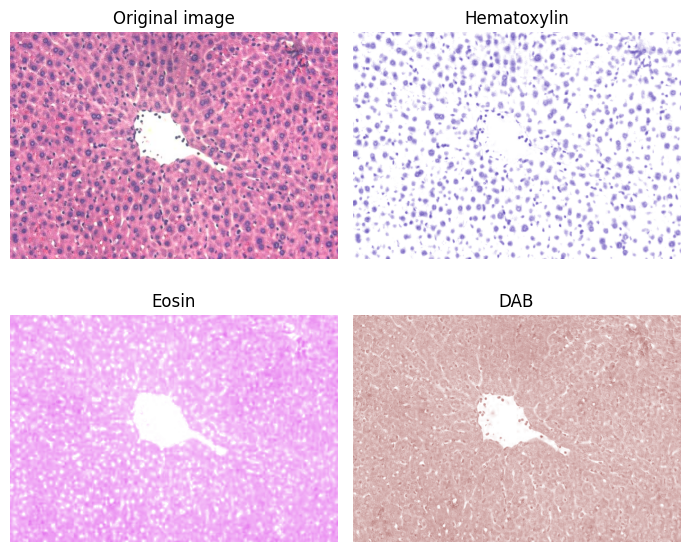

In [170]:
ihc_hed = rgb2hed(ihc_rgb)
ihc_hed = separate_stains_pyvips(pyvips_image).numpy()
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = combine_stains_pyvips(pyvips.Image.new_from_array(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))).numpy()
ihc_e = combine_stains_pyvips(pyvips.Image.new_from_array(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))).numpy()
ihc_d = combine_stains_pyvips(pyvips.Image.new_from_array(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))).numpy()

print(ihc_d.max())

fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[0].set_title("Original image")

ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_e)
ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image

ax[3].imshow(ihc_d)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

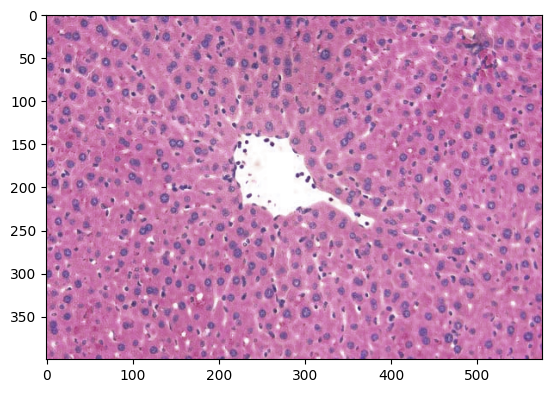

In [171]:
back = combine_stains_pyvips(pyvips.Image.new_from_array(ihc_hed))
plt.imshow(back)